In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [3]:
from time import time

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [6]:
class ModelFullyConnected(nn.Module):

    def __init__(self, num_hidden=1, hidden_size=32, dropout_rate=0.5):
        super(ModelFullyConnected, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Linear(self.input_size[0] * self.input_size[1], hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_size[0] * self.input_size[1])
        x = F.dropout(F.relu(self.input_layer(x)), p=self.dropout_rate)
        for layer in self.hidden_layers:
            x = F.dropout(F.relu(layer(x)), p=self.dropout_rate)
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)

In [7]:
class ModelConvolutional(nn.Module):

    def __init__(self, num_hidden=1, fc_hidden_size=32, dropout_rate=0.5, num_filters=16, filter_size=3):
        super(ModelConvolutional, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.num_filters = num_filters
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Conv2d(1, num_filters, filter_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Conv2d(num_filters, num_filters, filter_size))
        self.size_after_convs = (
            self.input_size[0] - (filter_size - 1) * (num_hidden + 1), 
            self.input_size[1] - (filter_size - 1) * (num_hidden + 1)
        )
        self.fc_layer = nn.Linear(self.size_after_convs[0] * self.size_after_convs[1] * num_filters, fc_hidden_size)
        self.output_layer = nn.Linear(fc_hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, 1, self.input_size[0], self.input_size[1])
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = x.view(-1, self.size_after_convs[0] * self.size_after_convs[1] * self.num_filters)
        #print(x.size())
        x = F.dropout(F.relu(self.fc_layer(x)), p=self.dropout_rate)
        #print(x.size())
        x = self.output_layer(x)
        #print(x.size())
        return F.log_softmax(x, dim=1)

In [8]:
class AdaSGD3():
    
    def __init__(self, params, init_base_lr=0., init_meta1_lr=0., init_meta2_lr=0.,
                 meta_top_lr=1e-3, meta_top_betas=(0.9, 0.999), meta_top_eps=1e-8):
        self.params = list(params)
        self.base_lr = nn.Parameter(torch.Tensor([init_base_lr]))
        self.base_lr.grad = torch.zeros_like(self.base_lr)
        self.meta1_lr = nn.Parameter(torch.Tensor([init_meta1_lr]))
        self.meta1_lr.grad = torch.zeros_like(self.meta1_lr)
        self.meta2_lr = nn.Parameter(torch.Tensor([init_meta2_lr]))
        self.meta2_lr.grad = torch.zeros_like(self.meta2_lr)
        self.meta_top_opt = optim.Adam([self.meta2_lr], lr=meta_top_lr, betas=meta_top_betas, eps=meta_top_eps)
        self.flat_grads = 0
        self.meta1_grads = 0
        self.meta2_grads = 0
        
    def step(self):
        grads = []
        for param in self.params:
            grads.append(param.grad.data.view(-1))
        self.flat_grads += torch.cat(grads)
        for param in self.params:
            param.data = param.data - self.base_lr.data[0] * param.grad.data 

    def meta1_step(self):
        grads = []
        for param in self.params:
            grads.append(param.grad.data.view(-1))
        flat_grads_new = torch.cat(grads)
        self.base_lr.grad.data = torch.clamp(
            torch.Tensor([-torch.sum(self.flat_grads * flat_grads_new)]), -1, 1
        )
        self.meta1_grads += self.base_lr.grad.data
        self.base_lr.data = self.base_lr.data - self.meta1_lr.data * self.base_lr.grad.data
        self.flat_grads = 0
        
    def meta2_step(self):
        self.meta1_lr.grad.data = torch.clamp(
            -self.meta1_grads * self.base_lr.grad.data, -1, 1
        )
        self.meta2_grads += self.meta1_lr.grad.data
        self.meta1_lr.data = self.meta1_lr.data - self.meta2_lr.data * self.meta1_lr.grad.data
        self.meta1_grads = 0

    def meta_top_step(self):
        self.meta_top_opt.zero_grad()
        self.meta2_lr.grad.data = torch.clamp(
            -self.meta2_grads * self.meta1_lr.grad.data, -1, 1
        )
        self.meta_top_opt.step()
        self.meta2_grads = 0
        

In [9]:
batch_size = 32
test_batch_size = 32
max_epoch = 20
do_validation = False

In [10]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [11]:
losses = {}
test_losses = {}
times = {}
learning_rates = {}

In [12]:
Model = ModelFullyConnected
model_kwargs = {
    'num_hidden': 2, 
    'hidden_size': 256, 
    'dropout_rate': 0.8
}
model_name = '_'.join(['fc'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

fc_num_hidden=2_hidden_size=256_dropout_rate=0.8


In [13]:
losses[model_name] = {}
test_losses[model_name] = {}
times[model_name] = {}
learning_rates[model_name] = {}

In [20]:
torch.manual_seed(123)

#meta_opt_names = []

run_count = 3

truncated_bptt_step = 10

for meta_top_lr in [1e-5, 1e-4, 1e-3]:
    opt_name = 'AdaSGD3' + '_bptt_steps=' + str(truncated_bptt_step) + '_meta_top_lr=' + str(meta_top_lr)
    print(opt_name)
    meta_opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = AdaSGD3(model.parameters(), meta_top_lr=meta_top_lr)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0

        start_time = time()

        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                do_meta1_step = ((global_step + 1) % truncated_bptt_step == 0)
                do_meta2_step = ((global_step + 1) % (truncated_bptt_step ** 2) == 0)
                do_meta3_step = ((global_step + 1) % (truncated_bptt_step ** 3) == 0)
                if do_meta1_step:
                    loss.backward(retain_graph=True)
                else:
                    loss.backward()
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                if do_meta1_step:
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                    model.zero_grad()
                    loss.backward()
                    opt.meta1_step()
                    
                if do_meta2_step:
                    opt.meta2_step()
                    
                if do_meta3_step:
                    opt.meta_top_step()
                    
                learning_rates[model_name][opt_name][run].append(opt.base_lr.data[0])
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print(
                'epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}; lr = {:.4f}; meta1_lr = {:.4f}; meta2_lr = {:.4f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss, opt.base_lr.data[0], opt.meta1_lr.data[0], opt.meta2_lr.data[0]
            ))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


AdaSGD3_bptt_steps=10_meta_top_lr=1e-05
epoch 1 took 8.1s; av_loss = 1.945; av_test_loss = 0.000; lr = 0.0028; meta1_lr = 0.0001; meta2_lr = 0.0000
epoch 2 took 8.3s; av_loss = 0.765; av_test_loss = 0.000; lr = 0.0450; meta1_lr = 0.0005; meta2_lr = 0.0000
epoch 3 took 8.3s; av_loss = 0.242; av_test_loss = 0.000; lr = 0.0740; meta1_lr = 0.0008; meta2_lr = 0.0000
epoch 4 took 7.2s; av_loss = 0.117; av_test_loss = 0.000; lr = 0.0828; meta1_lr = 0.0009; meta2_lr = 0.0001
epoch 5 took 7.7s; av_loss = 0.074; av_test_loss = 0.000; lr = 0.0842; meta1_lr = 0.0009; meta2_lr = 0.0001
epoch 6 took 7.9s; av_loss = 0.050; av_test_loss = 0.000; lr = 0.0850; meta1_lr = 0.0010; meta2_lr = 0.0001
epoch 7 took 8.0s; av_loss = 0.039; av_test_loss = 0.000; lr = 0.0838; meta1_lr = 0.0011; meta2_lr = 0.0001
epoch 8 took 7.9s; av_loss = 0.030; av_test_loss = 0.000; lr = 0.0839; meta1_lr = 0.0011; meta2_lr = 0.0001
epoch 9 took 7.8s; av_loss = 0.023; av_test_loss = 0.000; lr = 0.0828; meta1_lr = 0.0012; meta2_

epoch 16 took 8.3s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.0961; meta1_lr = 0.0033; meta2_lr = 0.0010
epoch 17 took 8.0s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.0967; meta1_lr = 0.0033; meta2_lr = 0.0010
epoch 18 took 7.9s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0968; meta1_lr = 0.0033; meta2_lr = 0.0010
epoch 19 took 7.9s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0969; meta1_lr = 0.0033; meta2_lr = 0.0010
epoch 20 took 7.7s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.0969; meta1_lr = 0.0033; meta2_lr = 0.0010

epoch 1 took 7.6s; av_loss = 1.646; av_test_loss = 0.000; lr = 0.0307; meta1_lr = 0.0008; meta2_lr = 0.0001
epoch 2 took 8.8s; av_loss = 0.417; av_test_loss = 0.000; lr = 0.0786; meta1_lr = 0.0022; meta2_lr = 0.0003
epoch 3 took 7.7s; av_loss = 0.146; av_test_loss = 0.000; lr = 0.0857; meta1_lr = 0.0022; meta2_lr = 0.0004
epoch 4 took 7.8s; av_loss = 0.078; av_test_loss = 0.000; lr = 0.0846; meta1_lr = 0.0021; meta2_lr = 0.0006
epoch 5 took 7.5s; av_

epoch 12 took 7.5s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.1072; meta1_lr = 0.0132; meta2_lr = 0.0075
epoch 13 took 7.4s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.1086; meta1_lr = 0.0132; meta2_lr = 0.0076
epoch 14 took 7.9s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.1097; meta1_lr = 0.0132; meta2_lr = 0.0078
epoch 15 took 7.4s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.1097; meta1_lr = 0.0132; meta2_lr = 0.0079
epoch 16 took 7.9s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1109; meta1_lr = 0.0132; meta2_lr = 0.0079
epoch 17 took 7.3s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1113; meta1_lr = 0.0132; meta2_lr = 0.0080
epoch 18 took 7.8s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1114; meta1_lr = 0.0132; meta2_lr = 0.0080
epoch 19 took 7.3s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1115; meta1_lr = 0.0132; meta2_lr = 0.0081
epoch 20 took 8.0s; av_loss = 0.000; av_test_loss = 0.000; lr = 0.1116; meta1_lr = 0.0132; meta2_lr = 0.0081

epoch 1 took 7.7s;

In [32]:
meta_opt_names = meta_opt_names[:-1]

In [ ]:
torch.manual_seed(123)

#opt_names = []

run_count = 3

for lr in [0.05]:
    opt_name = 'SGD' + '_lr=' + str(lr)
    print(opt_name)
    opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = optim.SGD(model.parameters(), lr=lr)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0

        start_time = time()

        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                loss.backward()
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                learning_rates[model_name][opt_name][run].append(lr)
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print('epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}; lr = {:.4f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss, lr
            ))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


SGD_lr=0.05
epoch 1 took 7.2s; av_loss = 0.193; av_test_loss = 0.000; lr = 0.0500
epoch 2 took 7.3s; av_loss = 0.116; av_test_loss = 0.000; lr = 0.0500
epoch 3 took 7.2s; av_loss = 0.076; av_test_loss = 0.000; lr = 0.0500
epoch 4 took 7.9s; av_loss = 0.054; av_test_loss = 0.000; lr = 0.0500
epoch 5 took 7.5s; av_loss = 0.041; av_test_loss = 0.000; lr = 0.0500
epoch 6 took 7.2s; av_loss = 0.029; av_test_loss = 0.000; lr = 0.0500
epoch 7 took 7.2s; av_loss = 0.023; av_test_loss = 0.000; lr = 0.0500
epoch 8 took 7.2s; av_loss = 0.018; av_test_loss = 0.000; lr = 0.0500
epoch 9 took 7.7s; av_loss = 0.013; av_test_loss = 0.000; lr = 0.0500
epoch 10 took 7.2s; av_loss = 0.010; av_test_loss = 0.000; lr = 0.0500
epoch 11 took 7.5s; av_loss = 0.006; av_test_loss = 0.000; lr = 0.0500
epoch 12 took 7.2s; av_loss = 0.006; av_test_loss = 0.000; lr = 0.0500
epoch 13 took 7.6s; av_loss = 0.003; av_test_loss = 0.000; lr = 0.0500
epoch 14 took 7.2s; av_loss = 0.001; av_test_loss = 0.000; lr = 0.0500
epo

In [17]:
def running_average(a, alpha=0.999):
    #a = np.array(a)
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i-1] + (1 - alpha) * a[i]
    return av

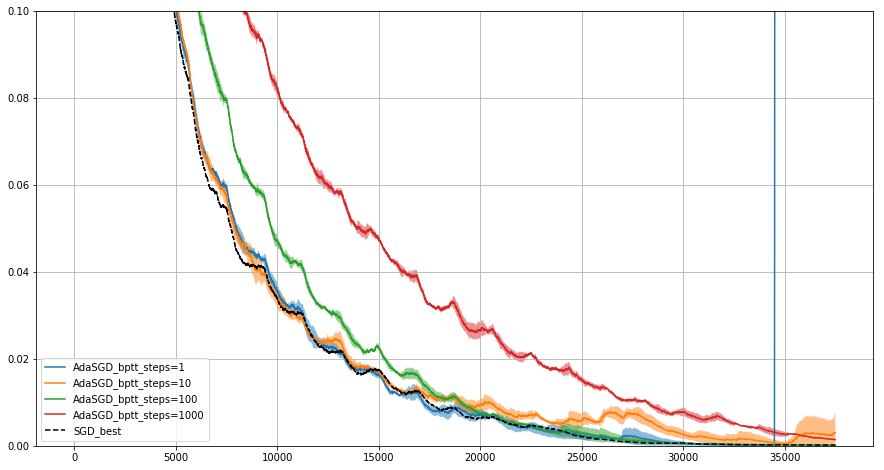

In [170]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
for opt_name in ['SGD_lr=0.05']:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

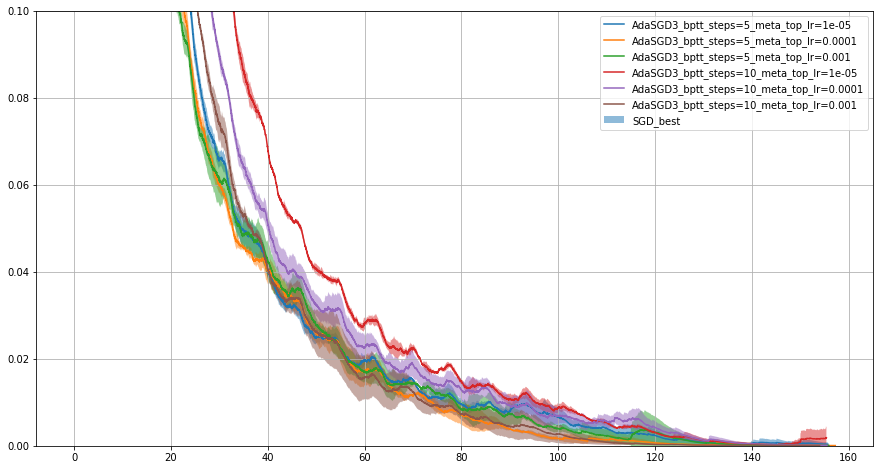

In [21]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
#for opt_name in ['SGD_lr=0.05']:
#    runs = running_average(losses[model_name][opt_name].T)
#    time_runs = times[model_name][opt_name].T
#    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

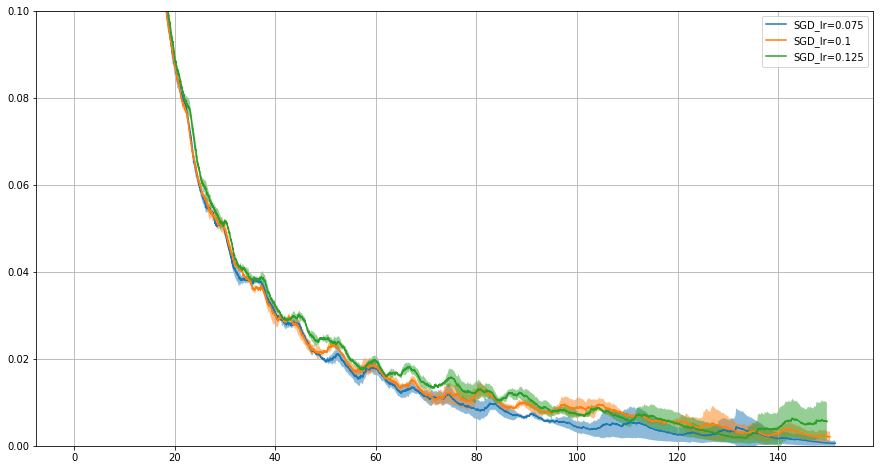

In [40]:
plt.figure(figsize=(15,8))
for opt_name in opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(opt_names)

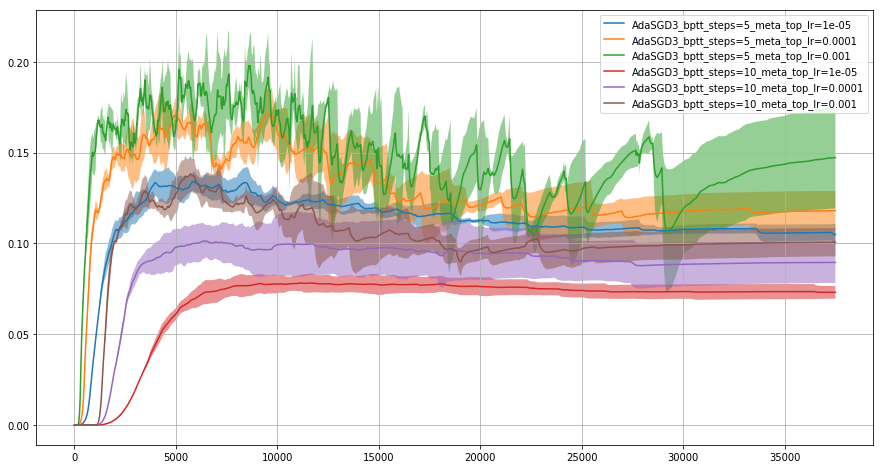

In [22]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(learning_rates[model_name][opt_name].T, alpha=0.99)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
#plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names)